# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd

if '..' not in sys.path:
    sys.path.insert(0, '..')

from src.m_utils import constants as cts
from src.base.data_loaders.data_loader import DLName
from src.base.gt_loaders.gt_names import GTName
from src.exp_runner import ExperimentRunner
from src.base.experiment.base_models import BaseModel
from src.base.experiment.optimizers import Optimizer
from src.base.experiment.model_evaluator import DataSource, DataPredSelection

2024-04-10 11:41:49.962360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-10 11:41:51.159101: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-10 11:41:51.197970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-10 11:41:51.198477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2024-04-10 11:41:51.198506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-10 11:41:51.202085: I tensorflow/stream_exec

[]


Exception: Invalid device or cannot modify virtual devices once initialized.

# Start Experiment Runner

In [5]:
def get_experiment_id(req, aligned, ds):
    df = pd.read_csv('../analysis/single_task_exps_data/icao-nets-training-2.csv')
    req_name = f"['{req.value.lower()}']"
    model_exp_id = df[(df['properties/icao_reqs'].str.contains(req_name, regex=False, case=False)) & 
                      (df['properties/aligned'] == float(aligned)) & 
                      (df['properties/gt_names'].str.contains(ds.value.lower()))].Id.values[0]
    return model_exp_id

assert get_experiment_id(cts.ICAO_REQ.MOUTH, False, GTName.FVC) == 'ICAO-164'

In [7]:
req = cts.ICAO_REQ.MOUTH
ds = GTName.FVC
aligned = False
aligned_str = 'aligned' if aligned else 'not_aligned'
model_name = f'{ds.value.lower()}_{aligned_str}/{req.value.lower()}'

model_exp_id = get_experiment_id(req, aligned, ds)

kwargs = { 
    'use_neptune': False,
    'exp_params' : {
        'name': 'train_vgg16',
        'description': f'Training network for {req.value.upper()} requisite',
        'tags': ['vgg16', 'ground truths', 'adamax', ds.value.lower(), 'binary_output', req.value.lower(), 'single_task', aligned_str],
        'src_files': ["src/*.py"]
    },
    'properties': {
#         'tagger_model': OpenfaceMouth(),
#         'dl_names': {'train_validation':
#                            [DLName.VGGFACE2, DLName.CALTECH, DLName.FVC_PYBOSSA, 
#                             DLName.CVL, DLName.FEI_DB, DLName.GEORGIA_TECH, DLName.COLOR_FERET,
#                             DLName.ICPR04, DLName.IMFDB, DLName.IJBC, DLName.LFW, DLName.CASIA_WF,
#                             DLName.GENKI4K_DB],
#                       'test': [],
        #'reqs': list(cts.ICAO_REQ),
        'reqs': [req],
        'aligned': aligned,
        'use_gt_data': True,
        'gt_names': {
            'train_validation': [],
            'test': [],
            'train_validation_test': [ds]
        },
        'balance_input_data': False,
        'train_model': False,
        'save_trained_model': True,
        'orig_model_experiment_id': model_exp_id,
        'sample_training_data': False,
        'sample_prop': 1.
    },
    'net_train_params': {
        'base_model': BaseModel.VGG16,
        'batch_size': 64,
        'n_epochs': 10,
        'early_stopping': 10,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {}
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 173870
Process ID: 174239
---------------------------
-----
Use Neptune:  False
-----
-------------------
Args: 
{'exp_params': {'description': 'Training network for MOUTH requisite',
                'name': 'train_vgg16',
                'src_files': ['src/*.py'],
                'tags': ['vgg16',
                         'ground truths',
                         'adamax',
                         'fvc',
                         'binary_output',
                         'mouth',
                         'single_task',
                         'not_aligned']},
 'nas_params': {},
 'net_train_params': {'base_model': <BaseModel.VGG16: {'target_size': (224, 224), 'prep_function': <function preprocess_input at 0x7f87734d0040>}>,
                      'batch_size': 64,
                      'dropout': 0.3,
                      'early_stopping': 10,
                      'learning_ra

# Load Data

In [5]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 4)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 4)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 4)
Data loaded


# Sampling Training Data

In [6]:
runner.sample_training_data()

-------------------- sample training data -------------------
Not applying subsampling in training data!


# Data Balancing

In [7]:
runner.balance_input_data()

-------------------- balance input data -------------------
Not balancing input_data


# Data Generators

In [8]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 4928 validated image filenames belonging to 2 classes.
Found 547 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.
TOTAL: 5763

Logging class indices
 ..Train Generator: {'0': 0, '1': 1}
 ..Valid Generator: {'0': 0, '1': 1}
 ..Test Generator: {'0': 0, '1': 1}

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Setup Experiment

In [9]:
runner.setup_experiment()

-------------------- create experiment -------------------
Setup neptune properties and parameters
Properties and parameters setup done!


# Labels Distribution

In [10]:
runner.summary_labels_dist()

-------------------- summary labels dist -------------------
Requisite: MOUTH
N_TRAIN_COMP: 3607 (73.19%)
N_TRAIN_NOT_COMP: 1321 (26.81%)
N_TRAIN_DUMMY: 0 (0.0%)
N_VALIDATION_COMP: 420 (76.78%)
N_VALIDATION_NOT_COMP: 127 (23.22%)
N_VALIDATION_DUMMY: 0 (0.0%)
N_TEST_COMP: 215 (74.65%)
N_TEST_NOT_COMP: 73 (25.35%)
N_TEST_DUMMY: 0 (0.0%)
----


In [11]:
runner.summary_gen_labels_dist()

-------------------- summary gen labels dist -------------------
GEN_N_TRAIN_COMP: 3607 (73.19%)
GEN_N_TRAIN_NON_COMP: 1321 (26.81%)
GEN_N_TRAIN_DUMMY: 0 (0.0%)
GEN_N_VALID_COMP: 420 (76.78%)
GEN_N_VALID_NON_COMP: 127 (23.22%)
GEN_N_VALID_DUMMY: 0 (0.0%)
GEN_N_TEST_COMP: 215 (74.65%)
GEN_N_TEST_NON_COMP: 73 (25.35%)
GEN_N_TEST_DUMMY: 0 (0.0%)


# Create Model

In [12]:
runner.create_model()

-------------------- create model -------------------
Creating model...
Model created


# Vizualize Model

-------------------- vizualize model -------------------


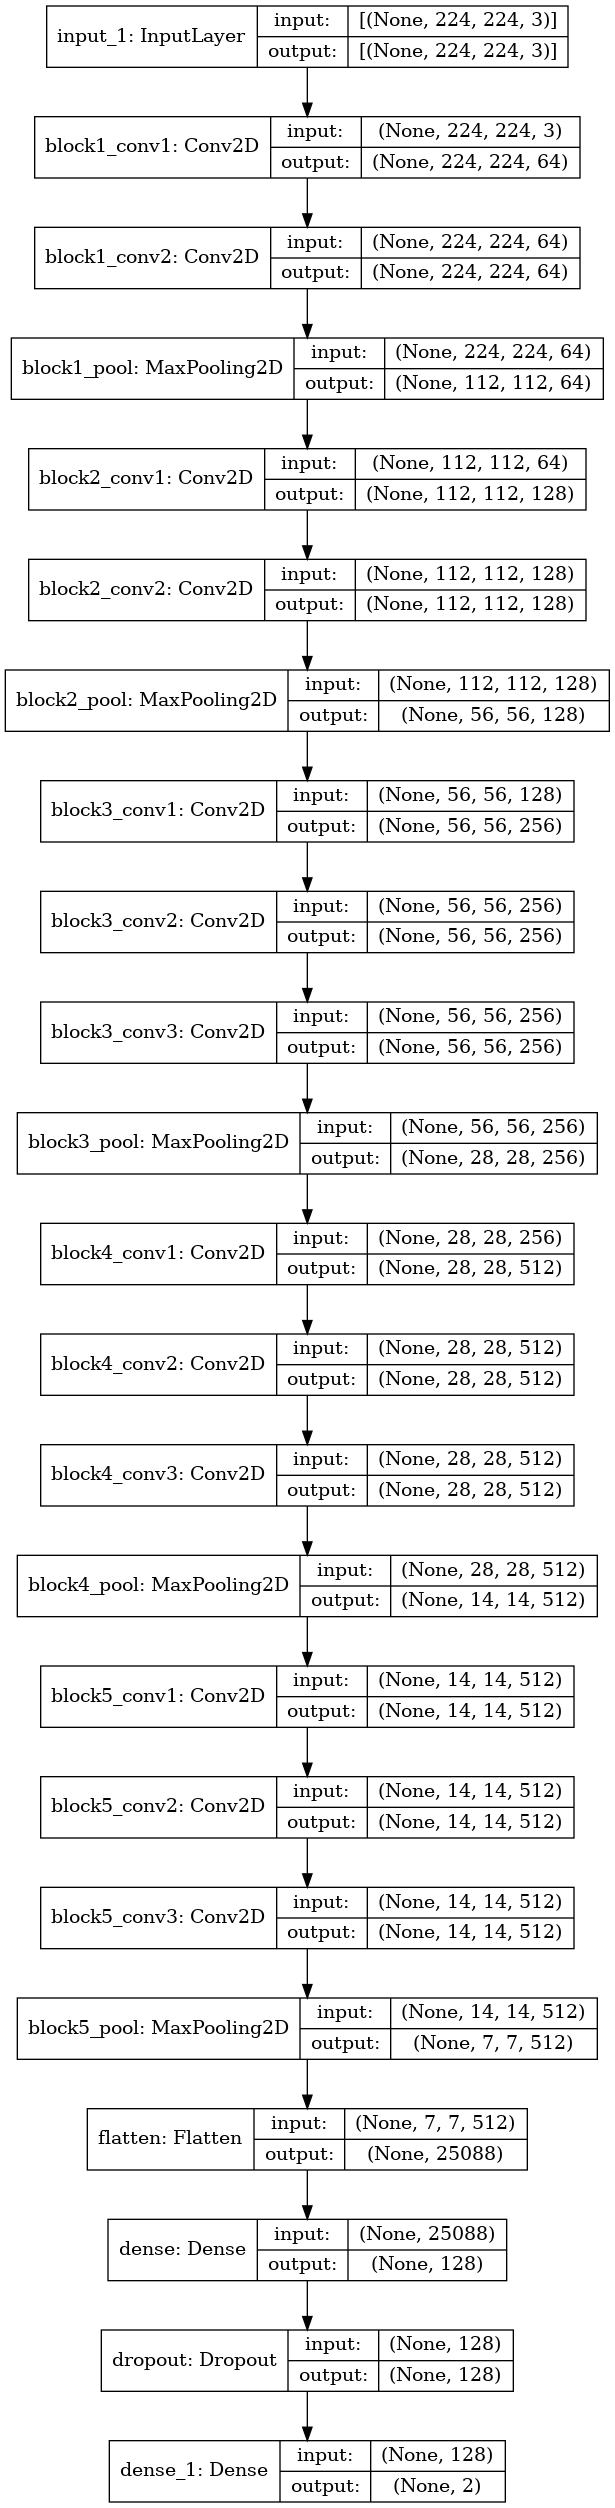

In [13]:
runner.vizualize_model(outfile_path=f"figs/{model_name.replace('/','_')}.png")

In [14]:
runner.model_summary()

Not training a model!


# Training Model

In [15]:
runner.train_model()

-------------------- train model -------------------
Not training a model. Downloading data from Neptune
 ..Experiment ID: ICAO-38
 ..Downloading data from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-38
 ..Download finished
 ..Upload data to current experiment
 ..Upload finished


# Plots

In [16]:
runner.draw_training_history()

-------------------- draw training history -------------------
Not training a model. Downloading plot from Neptune
 ..Experiment ID: ICAO-38
 ..Downloading plot from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-38
 ..Download finished
 ..Uploading plot
 ..Upload finished


# Load Best Model

In [17]:
runner.load_best_model()

-------------------- load best model -------------------
..Loading best model
..Model loaded
...Model path: prev_trained_models/single_task/fvc_not_aligned/mouth/ICAO-38


# Saving Trained Model

In [18]:
runner.save_model()

-------------------- save model -------------------
Saving model
INFO:tensorflow:Assets written to: prev_trained_models/single_task/fvc_not_aligned/mouth/ICAO-38/assets
..Model saved
...Model path: prev_trained_models/single_task/fvc_not_aligned/mouth/ICAO-38
Saving model to neptune
 ..Uploading file trained_model.zip
Model saved into Neptune
Saving process finished


# Test Trained Model

## Validation Split

Testing Trained Model
Predicting labels....
9/9 [==============================] - 34s 4s/step
Prediction finished!
Requisite: MOUTH


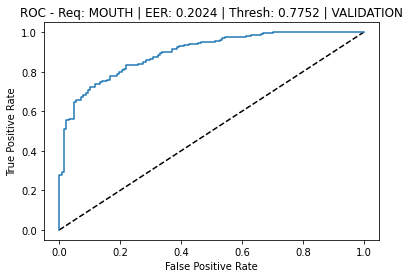

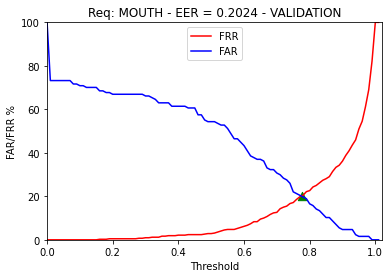

Requisite: MOUTH - EER_interp: 20.24% - Best Threshold: 0.7752287692966915
Classification report -----------------------------------
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       127
           1       0.93      0.80      0.86       420

    accuracy                           0.80       547
   macro avg       0.74      0.80      0.75       547
weighted avg       0.84      0.80      0.81       547

Confusion matrix ----------------------------------------
FAR: 19.689999999999998% | FRR: 20.24% | EER_mean: 19.96% | TP: 335 | TN: 102 | FP: 25 | FN: 85
Accuracy ------------------------------------------------
Model Accuracy: 79.89%
---------------------------------------------------------


In [19]:
runner.set_model_evaluator_data_src(DataSource.VALIDATION)
runner.test_model()

### Vizualize Model Classification

-------------------- vizualize predictions -------------------
Logging sample of ANY_IMGS images to Neptune


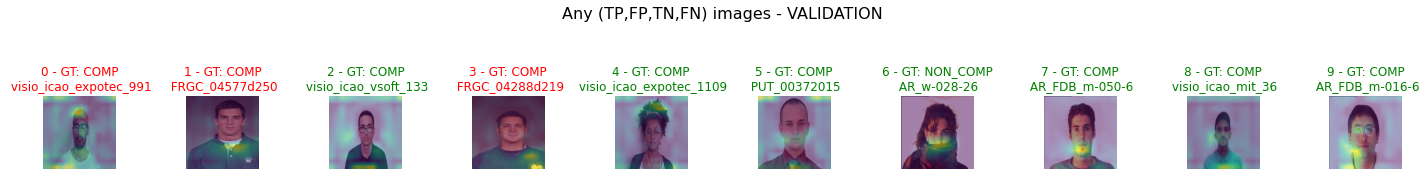

In [20]:
runner.vizualize_predictions(n_imgs=10)

#### False Positives

-------------------- vizualize predictions -------------------
Logging sample of FP_ONLY images to Neptune


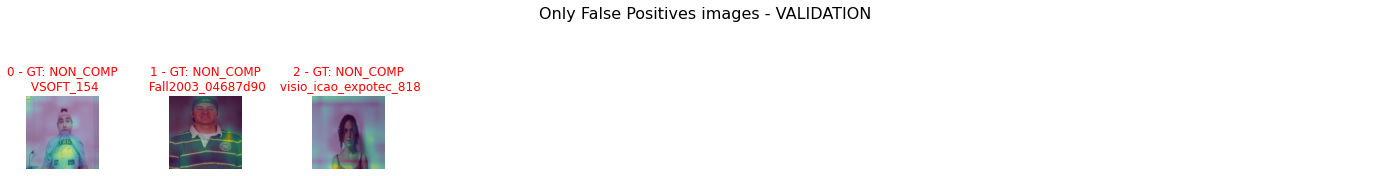

In [21]:
runner.vizualize_predictions(n_imgs=3, data_pred_selection=DataPredSelection.ONLY_FP)

#### False Negatives

-------------------- vizualize predictions -------------------
Logging sample of FN_ONLY images to Neptune


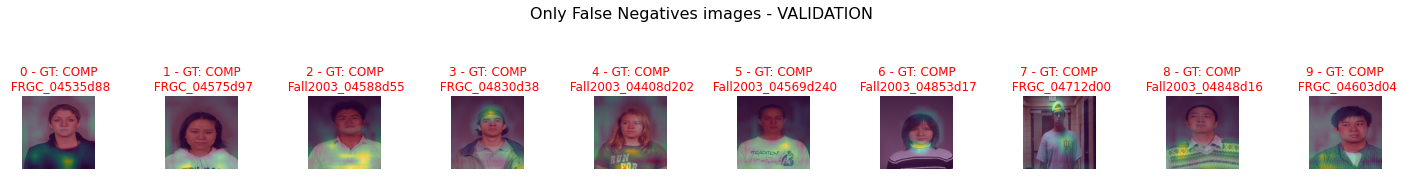

In [22]:
runner.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FN)

#### True Positives

-------------------- vizualize predictions -------------------
Logging sample of TP_ONLY images to Neptune


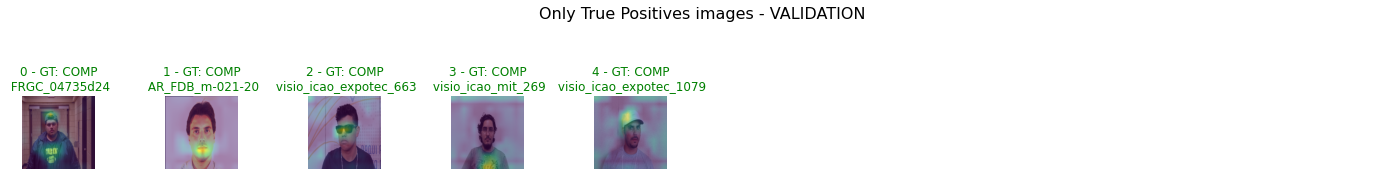

In [24]:
runner.vizualize_predictions(n_imgs=5, data_pred_selection=DataPredSelection.ONLY_TP)

#### True Negatives

-------------------- vizualize predictions -------------------
Logging sample of TN_ONLY images to Neptune


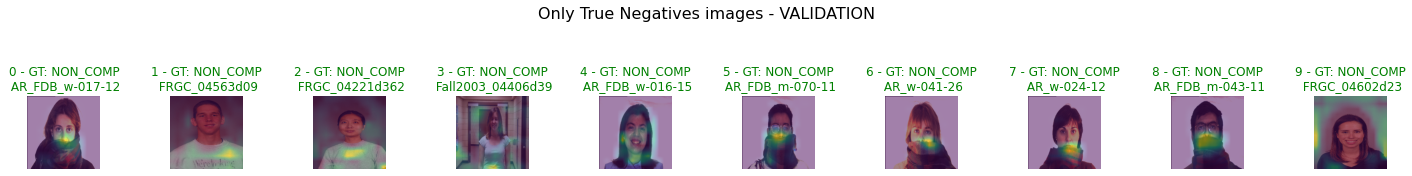

In [25]:
runner.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TN)

## Test Split

Testing Trained Model
Predicting labels....
5/5 [==============================] - 18s 4s/step
Prediction finished!
Requisite: MOUTH


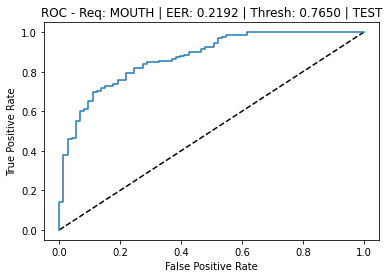

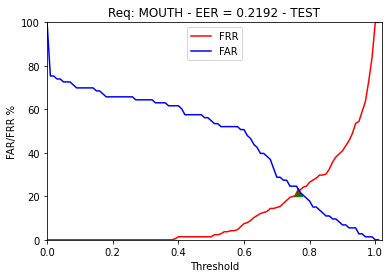

Requisite: MOUTH - EER_interp: 21.92% - Best Threshold: 0.7649792432783892
Classification report -----------------------------------
              precision    recall  f1-score   support

           0       0.56      0.78      0.66        73
           1       0.91      0.80      0.85       215

    accuracy                           0.79       288
   macro avg       0.74      0.79      0.75       288
weighted avg       0.83      0.79      0.80       288

Confusion matrix ----------------------------------------
FAR: 21.92% | FRR: 20.47% | EER_mean: 21.2% | TP: 171 | TN: 57 | FP: 16 | FN: 44
Accuracy ------------------------------------------------
Model Accuracy: 79.17%
---------------------------------------------------------


In [26]:
runner.set_model_evaluator_data_src(DataSource.TEST)
runner.test_model()

### Vizualize Model Classification

-------------------- vizualize predictions -------------------
Logging sample of ANY_IMGS images to Neptune


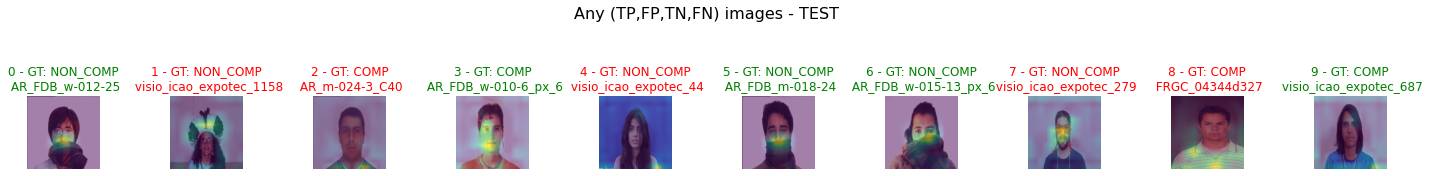

In [27]:
runner.vizualize_predictions(n_imgs=10)

#### False Positives

-------------------- vizualize predictions -------------------
Logging sample of FP_ONLY images to Neptune


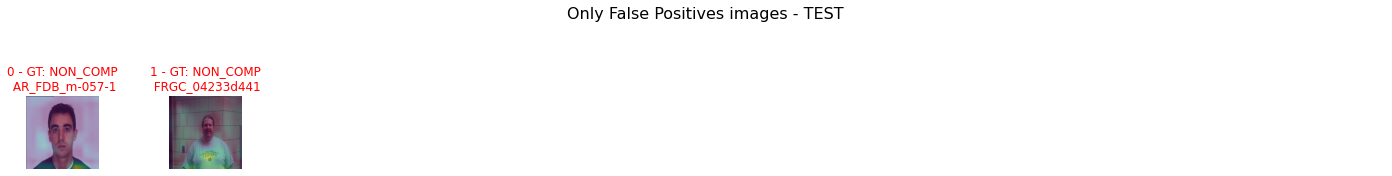

In [31]:
runner.vizualize_predictions(n_imgs=2, data_pred_selection=DataPredSelection.ONLY_FP)

#### False Negatives

-------------------- vizualize predictions -------------------
Logging sample of FN_ONLY images to Neptune


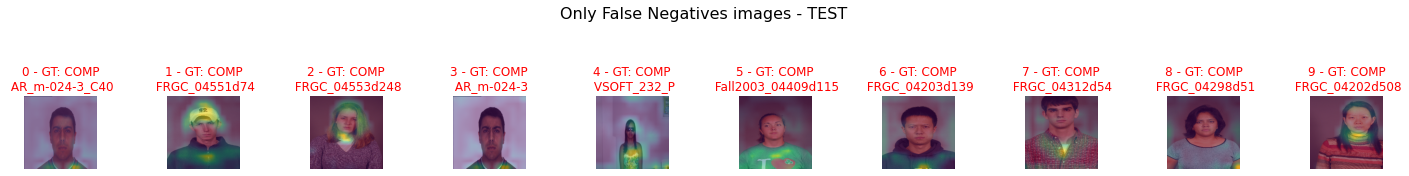

In [32]:
runner.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_FN)

#### True Positives

-------------------- vizualize predictions -------------------
Logging sample of TP_ONLY images to Neptune


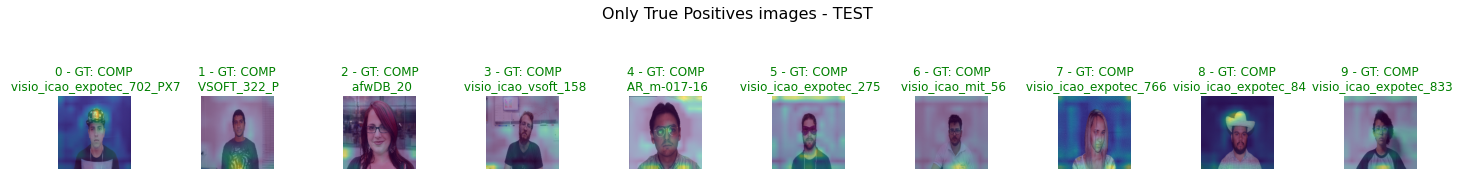

In [33]:
runner.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TP)

#### True Negatives

-------------------- vizualize predictions -------------------
Logging sample of TN_ONLY images to Neptune


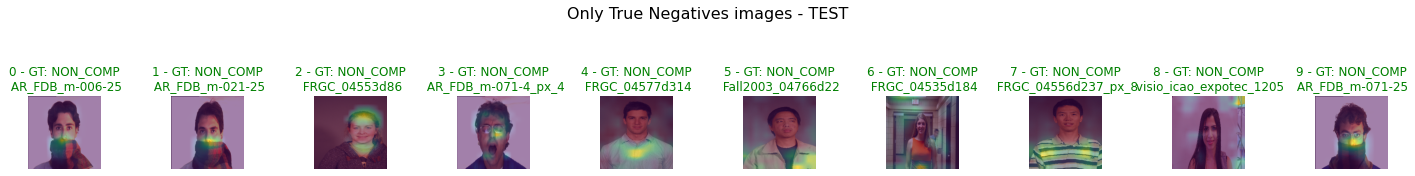

In [34]:
runner.vizualize_predictions(n_imgs=10, data_pred_selection=DataPredSelection.ONLY_TN)

# Finishing Experiment Manager

In [35]:
runner.finish_experiment()

-------------------- finish experiment -------------------
Finishing Neptune
